In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from sklearn import metrics

trialOrders = {}

import os

path = './events'

def compute_skourascore(subject_performace, idealized_performance):
    return scipy.stats.pearsonr(subject_performace, idealized_performance)[0]

def compute_auc_score(counterbalanced_angles, length):
    score = metrics.auc(np.arange(length * 1.0), counterbalanced_angles) / metrics.auc(np.arange(length * 1.0), np.full((length, 1), 90))
    return score

def compute_peak_score(counterbalanced_angles):
    return np.amax(counterbalanced_angles)

def compute_ttp_score(counterbalanced_angles):
    return np.argmax(counterbalanced_angles)

def find_empty_times(data):
    intermissions = data[data['instruction']==" Push Button"].index.tolist()
    rests = data[data['instruction']==" Rest"]
    first_scan_index = data[data['instruction']!=" Rest"].index.tolist()[0] - 1
    first_rest_at_end = data[data['instruction']!=" Rest"].index.tolist()[-1] + 1
    times = [first_scan_index] + intermissions + [first_rest_at_end]
    return times

def determine_trialorder(data, times):
    trialOrder = []
    for trialnum in range(12):
        this_trial = data[(times[trialnum] + 1):times[trialnum + 1]][data['feedback']=="On"]
        trialOrder += [this_trial['left_text'].tolist()[0][1:] + "-" + this_trial['right_text'].tolist()[0][1:], this_trial['instruction'].tolist()[0][1:]]
    return trialOrder

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.tsv' in file:
            files.append(os.path.join(r, file))
            

In [2]:
import copy
means_template = {'ID':[], 'down': [], 'up': [], 'both': []}

series_template = {'ID':[]}
for i in range(1, 13):
    series_template[str(i)] = []

downseries_template = {'ID':[]}
for i in range(1, 7):
    downseries_template[str(i)] = []
    
upseries_template = {'ID':[]}
for i in range(1, 7):
    upseries_template[str(i)] = []

skouradict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}
aucdict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}
peakdict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}
ttpdict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}

for i in range(len(files)):
    #parsing filename to find NKI subject ID
    subpos = files[i].find('sub-A')
    subjID = files[i][(subpos + 4):(subpos + 13)]
    #reading events.tsv file as "data"
    data = pd.read_csv(files[i], sep="\t")
    times = find_empty_times(data)
    trialOrder = determine_trialorder(data, times)
    
    skouradict['series']['ID'] += [subjID]
    skouradict['upseries']['ID'] += [subjID]
    skouradict['downseries']['ID'] += [subjID]
    
    aucdict['series']['ID'] += [subjID]
    aucdict['upseries']['ID'] += [subjID]
    aucdict['downseries']['ID'] += [subjID]
    
    peakdict['series']['ID'] += [subjID]
    peakdict['upseries']['ID'] += [subjID]
    peakdict['downseries']['ID'] += [subjID]
    
    ttpdict['series']['ID'] += [subjID]
    ttpdict['upseries']['ID'] += [subjID]
    ttpdict['downseries']['ID'] += [subjID]
    
    series_position = 1
    downseries_position = 1
    upseries_position = 1
    
    for trialnum in range(12):
        #this_trial is the data just from the trial of trialnum
        #this_trial is set to the FIRST 15 TRs (first 30 seconds) of each trial!
        this_trial = data[(times[trialnum] + 1):times[trialnum + 1]]#[0:16]
        length = len(this_trial.needle_position.values)
        instruction = trialOrder[(trialnum * 2) + 1]
        polarity = trialOrder[(trialnum * 2)]
        if instruction == "Focus":
            if polarity == 'Focused-Wandering':
                idealized = np.linspace(90, 90 + (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90)
            elif polarity == 'Wandering-Focused':
                idealized = np.linspace(90, 90 - (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90) * -1
            
            #calculating scores
            auc = compute_auc_score(auc_balanced, length)
            skourascore = compute_skourascore(this_trial.needle_position.values, idealized)
            peak = compute_peak_score(auc_balanced)
            ttp = compute_ttp_score(auc_balanced)
            
            #storing scores in memory
            skouradict['downseries'][str(downseries_position)] += [skourascore]
            aucdict['downseries'][str(downseries_position)] += [auc]
            peakdict['downseries'][str(downseries_position)] += [peak]
            ttpdict['downseries'][str(downseries_position)] += [ttp]
            
            downseries_position += 1
        elif instruction == "Wander":
            if polarity == 'Focused-Wandering':
                idealized = np.linspace(90, 90 - (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90) * -1
            elif polarity == 'Wandering-Focused':
                idealized = np.linspace(90, 90 + (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90)
            
            #calculating scores
            auc = compute_auc_score(auc_balanced, length)
            skourascore = compute_skourascore(this_trial.needle_position.values, idealized)
            peak = compute_peak_score(auc_balanced)
            ttp = compute_ttp_score(auc_balanced)
            
            #storing scores in memory
            skouradict['upseries'][str(upseries_position)] += [skourascore]
            aucdict['upseries'][str(upseries_position)] += [auc]
            peakdict['upseries'][str(upseries_position)] += [peak]
            ttpdict['upseries'][str(upseries_position)] += [ttp]
            
            upseries_position += 1
        else:
            print("something is horribly wrong")
        skouradict['series'][str(series_position)] += [skourascore]
        aucdict['series'][str(series_position)] += [auc]
        peakdict['series'][str(series_position)] += [peak]
        ttpdict['series'][str(series_position)] += [ttp]
        
        series_position += 1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [3]:
#convert series dicts into dataframes
#first skourascores
skouraseries = pd.DataFrame(skouradict['series'])
skouradownseries = pd.DataFrame(skouradict['downseries'])
skouraupseries = pd.DataFrame(skouradict['upseries'])
#now AUC scores
aucseries = pd.DataFrame(aucdict['series'])
aucdownseries = pd.DataFrame(aucdict['downseries'])
aucupseries = pd.DataFrame(aucdict['upseries'])
#now peak scores
ttpseries = pd.DataFrame(ttpdict['series'])
ttpdownseries = pd.DataFrame(ttpdict['downseries'])
ttpupseries = pd.DataFrame(ttpdict['upseries'])
#now TTP scores
peakseries = pd.DataFrame(peakdict['series'])
peakdownseries = pd.DataFrame(peakdict['downseries'])
peakupseries = pd.DataFrame(peakdict['upseries'])

#now sort them by IDs
skouraseries.sort_values(by=['ID'])
skouradownseries.sort_values(by=['ID'])
skouraupseries.sort_values(by=['ID'])
aucseries.sort_values(by=['ID'])
aucdownseries.sort_values(by=['ID'])
aucupseries.sort_values(by=['ID'])
ttpseries.sort_values(by=['ID'])
ttpdownseries.sort_values(by=['ID'])
ttpupseries.sort_values(by=['ID'])
peakseries.sort_values(by=['ID'])
peakdownseries.sort_values(by=['ID'])
peakupseries.sort_values(by=['ID'])
None;

Function for calculating skouras-style "learning" score. "learning" in this context is measured as the average of trials 4-6 minus the average of trials 1-3. This "learning" measurement is independent of score-type, and can be calculated for each one.

It also calculates the 6-1 learning measure.

I define a function for calculating "learning" here.

In [4]:
#this function assumes a trial-series of length 6 (either up or down regulation, but not both)
def add_learning_measures(series):
    series['first_avg'] = series[['1', '2','3']].mean(axis=1)
    series['second_avg'] = series[['4', '5','6']].mean(axis=1)
    series['skouras_learning'] = series['second_avg'] - series['first_avg']
    series['six_minus_one'] = series['6'] - series['1']
    series['difference_between_measures'] = series['six_minus_one'] - series['skouras_learning']
    return series

In [5]:
%matplotlib notebook

Create function for plotting learning curves and histograms of arbitrary # of trials

In [6]:
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

def learningcurve(seriesdata, length, scoretype):
    x = []
    for i in range(length):
        x += [i + 1]

    series = pd.DataFrame(seriesdata)
    series = series.sort_values(by=['ID'])
    series = series.to_numpy()
    fig, ax = plt.subplots(2, 1)
    diffs = []
    for j in range(len(series)):
        x=np.asarray(x).astype(np.float)
        ax[0].scatter(x, series[j][1:], color='b', alpha=0.1)
        diffs += [series[j][6] - series[j][1]]
        y = series[j][1:].astype(np.float)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"r", alpha=0.2)
    ax[1].hist(diffs, 4)
    # set ticks and tick labels
    ax[0].set_xlim((1, length))
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(x)

    plt.xlabel('Trial Position (not the actual trial number)')
    plt.ylabel('Score')
    plt.title(scoretype + ' learning curves')
    plt.tight_layout()

    plt.show()
    
def series_histogram(seriesdata, scoretype, length, n_bins):
    series = pd.DataFrame(seriesdata)
    series = series.sort_values(by=['ID'])

    fig, axs = plt.subplots(length, 1, sharey=True, sharex=True)
    for trialPos in range(length):
        axs[trialPos].hist(series[str(trialPos + 1)].to_list(), bins=n_bins)
        axs[trialPos].set_title(scoretype + ' Trial ' + str(trialPos + 1))
    plt.xlabel('Score')
    plt.tight_layout()
    plt.show()

AUC score
Average difference between measures = 0.07292300752328128
skouras_learning measure has a variance of 0.05376020462044206
6-1 measure has a variance of 0.11361391997136128
Here is a random sample of 10 subjects.
     skouras_learning  six_minus_one  difference_between_measures
21          -0.051283       0.102466                     0.153749
15          -0.098197      -0.268240                    -0.170043
116          0.189650       0.339074                     0.149424
66           0.322218       0.343966                     0.021748
128          0.525400       0.727127                     0.201727
31           0.399980       0.604740                     0.204760
46           0.235204       0.587108                     0.351904
88           0.012290       0.127286                     0.114996
134         -0.040298       0.481405                     0.521703
35          -0.043040      -0.049686                    -0.006646


<IPython.core.display.Javascript object>


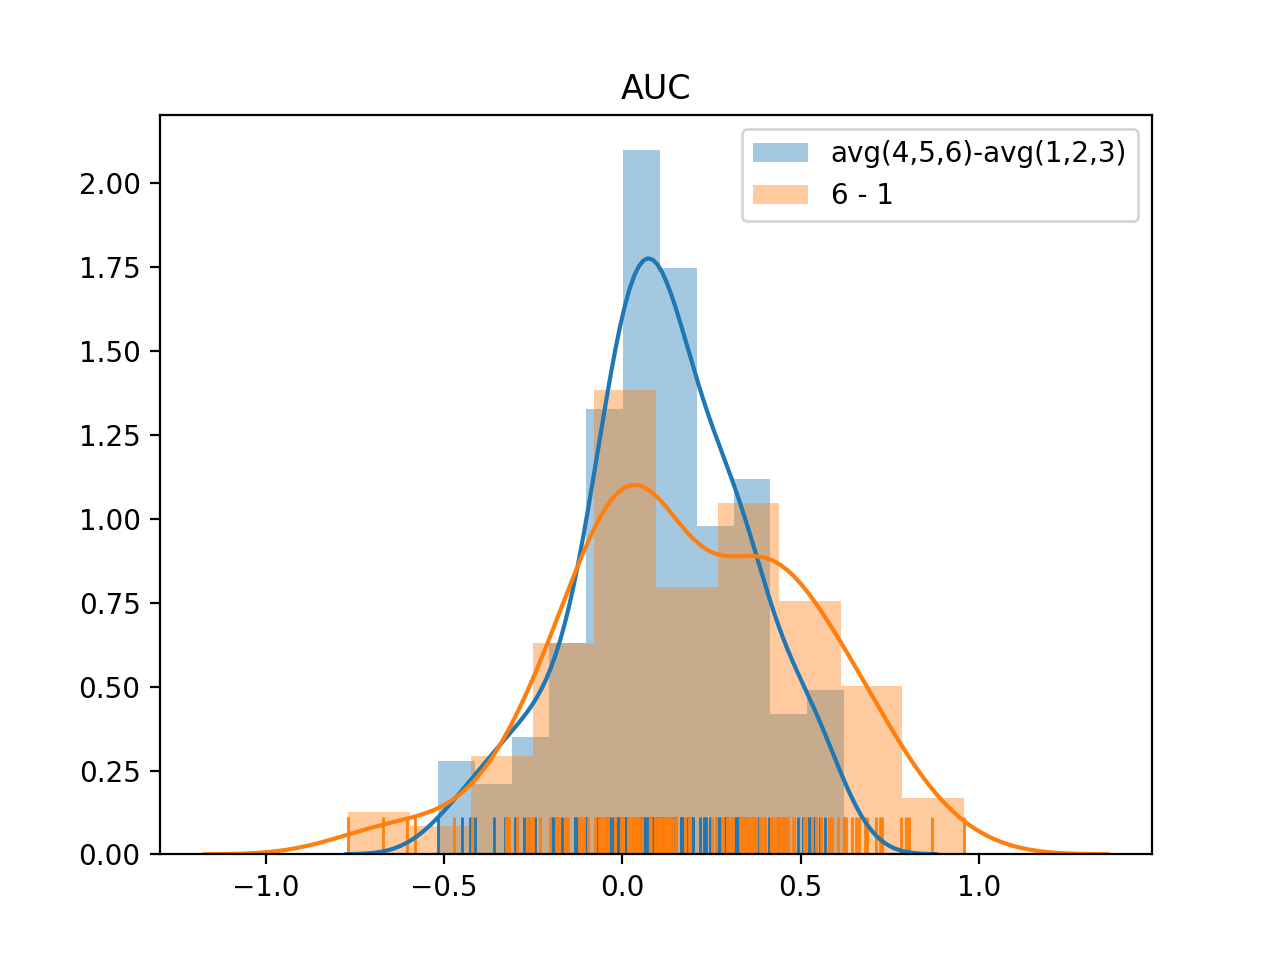

Skouras-Score score
Average difference between measures = 0.1638014520596817
skouras_learning measure has a variance of 0.3380568906533712
6-1 measure has a variance of 0.8905231804719707
Here is a random sample of 10 subjects.
     skouras_learning  six_minus_one  difference_between_measures
83           0.239878       0.284205                     0.044327
14          -0.855818       0.414952                     1.270771
34           0.303341       0.246104                    -0.057237
39           1.091686       1.649825                     0.558139
16          -0.140472       0.044932                     0.185403
12          -0.008570       1.501677                     1.510247
100          0.845040       1.890985                     1.045945
27          -0.328337       1.170855                     1.499192
110          0.775416       1.337929                     0.562512
7            0.574384      -0.047878                    -0.622261


<IPython.core.display.Javascript object>


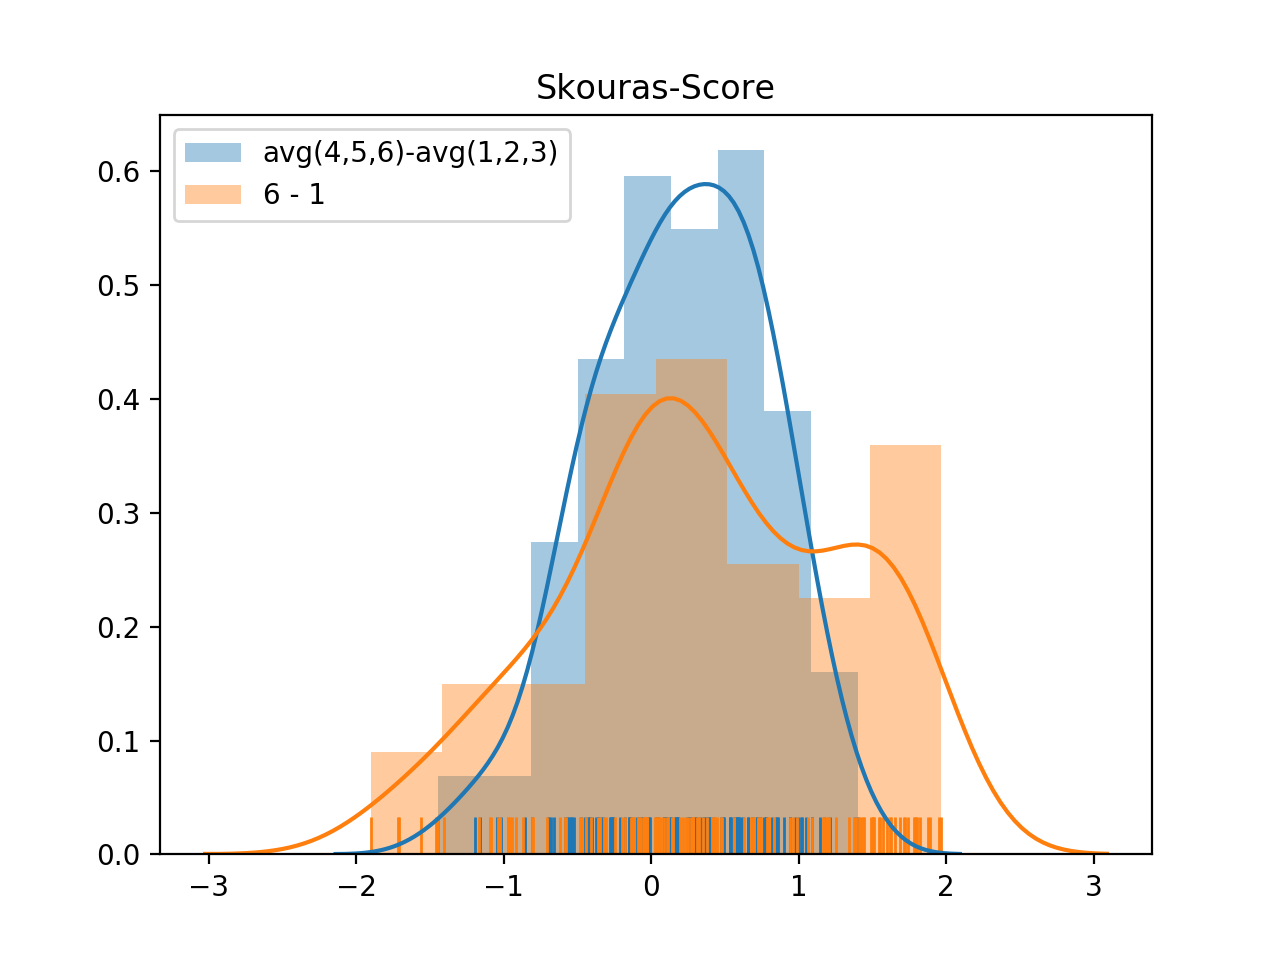

Time-to-peak score
Average difference between measures = -1.9927536231884053
skouras_learning measure has a variance of 66.47574039067423
6-1 measure has a variance of 459.1031821045999
Here is a random sample of 10 subjects.
    skouras_learning  six_minus_one  difference_between_measures
83          9.666667            -11                   -20.666667
51          1.666667              3                     1.333333
15          4.333333             -6                   -10.333333
60          3.666667              6                     2.333333
68         -3.666667              3                     6.666667
7           3.666667              4                     0.333333
25          9.000000            -27                   -36.000000
57         13.000000             38                    25.000000
9           2.333333             34                    31.666667
90          0.666667            -10                   -10.666667


<IPython.core.display.Javascript object>


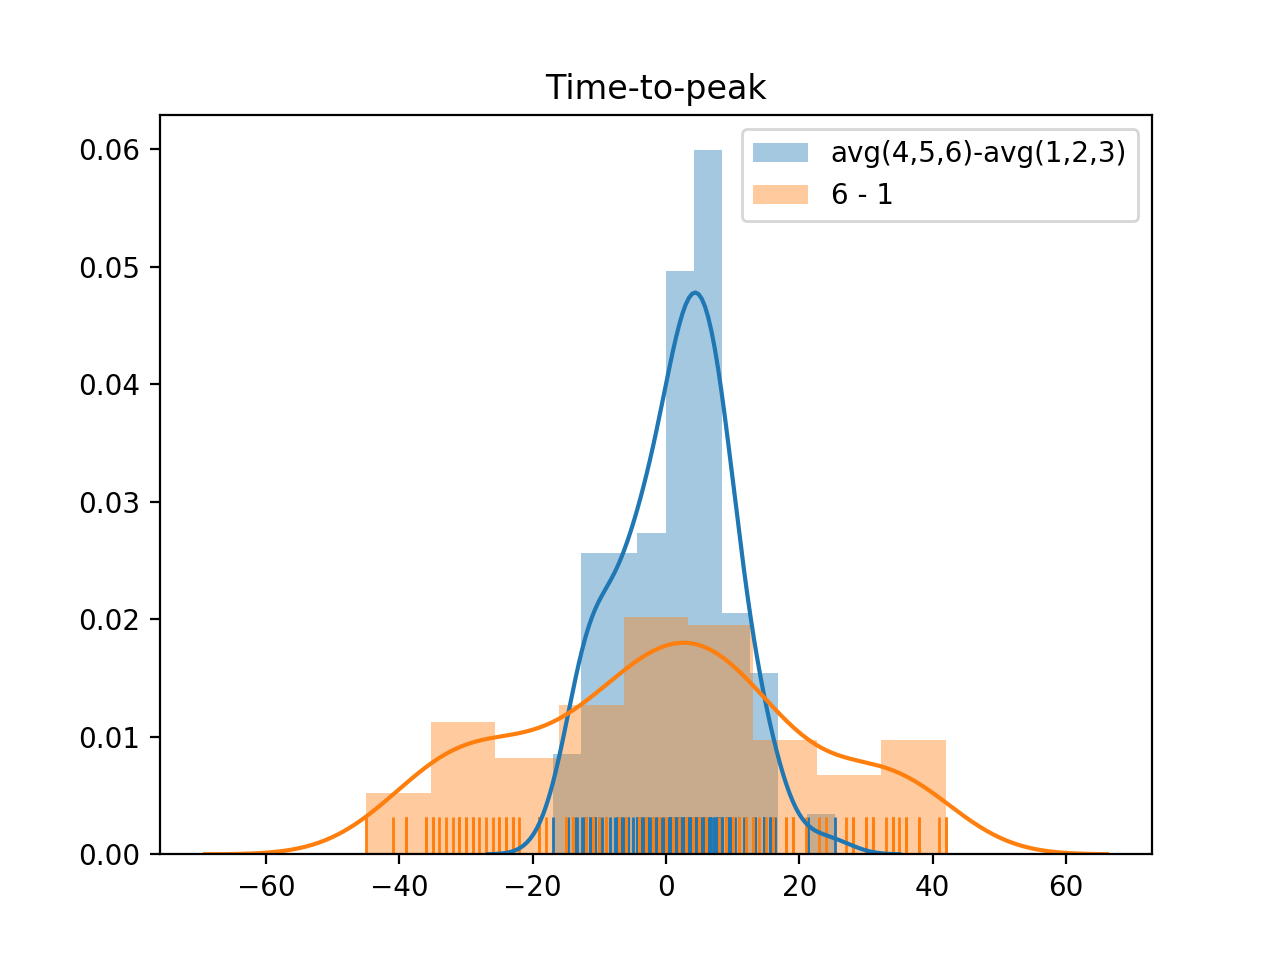

Peak score
Average difference between measures = 12.88526811594203
skouras_learning measure has a variance of 474.5868717101449
6-1 measure has a variance of 1478.3184356744907
Here is a random sample of 10 subjects.
     skouras_learning  six_minus_one  difference_between_measures
74          25.838333         -6.178                   -32.016333
32         -18.622000        -13.611                     5.011000
21          -8.971333         32.291                    41.262333
47          30.424000         83.705                    53.281000
23          34.238667         41.058                     6.819333
77           9.444000          8.682                    -0.762000
75          50.255000         29.475                   -20.780000
128         53.885667         88.187                    34.301333
114         11.291667         83.887                    72.595333
98           6.208000         77.650                    71.442000


<IPython.core.display.Javascript object>


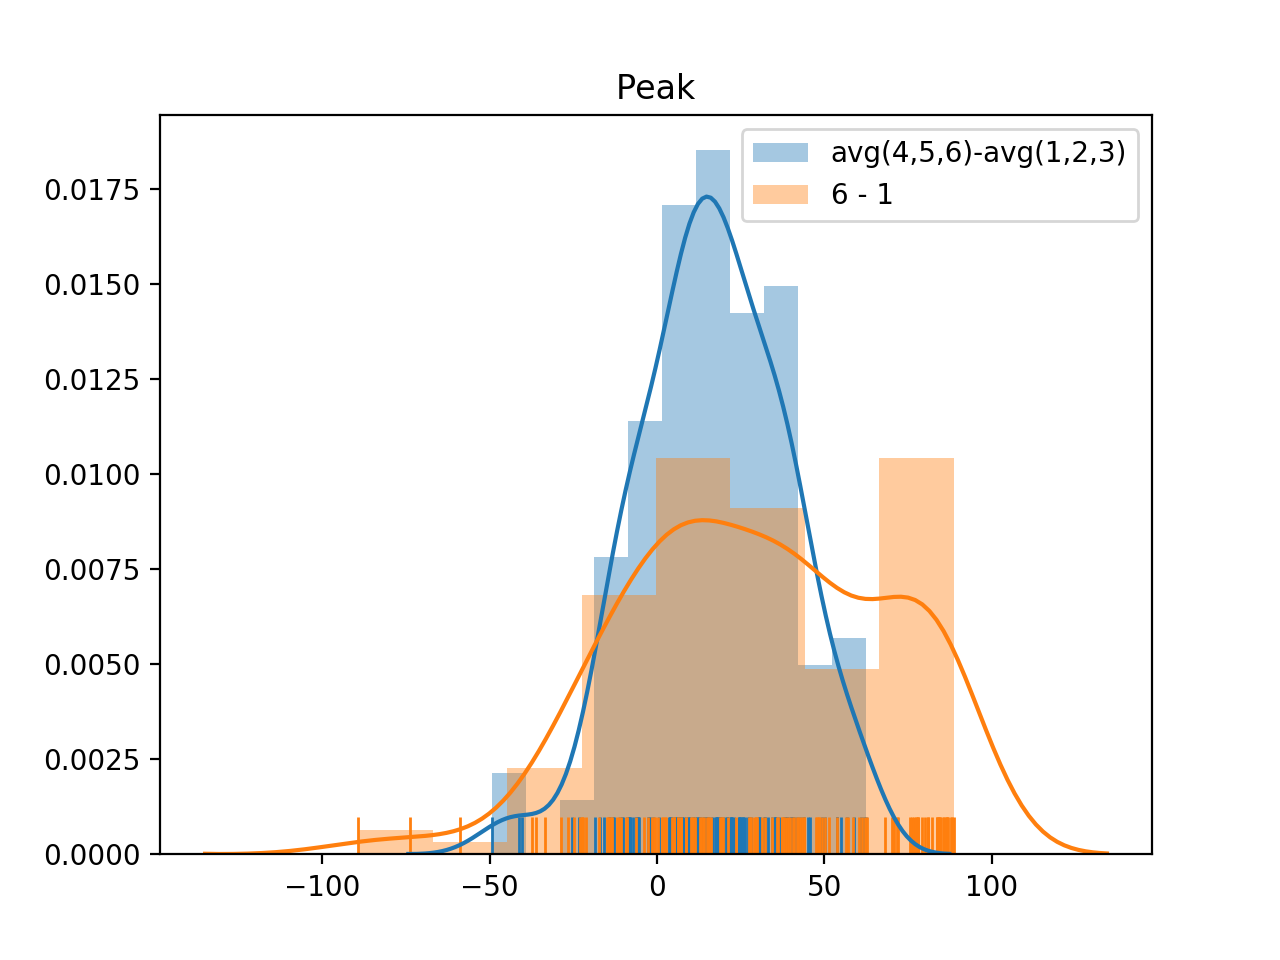

In [7]:
%matplotlib notebook
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

def learning_hist(series, title, dosample=False):
    if dosample:
        print(title, "score")
        print("Average difference between measures =", series['difference_between_measures'].mean(axis=0))
        print('skouras_learning measure has a variance of', np.var(series[['skouras_learning']].values))
        print('6-1 measure has a variance of', np.var(series[['six_minus_one']].values))
        print("Here is a random sample of 10 subjects.")
        print(series[['skouras_learning','six_minus_one', 'difference_between_measures']].sample(10))
    plt.figure()
    x = series[['skouras_learning']].values
    y = series[['six_minus_one']].values
    sns.distplot(x, kde=True, rug=True, label="avg(4,5,6)-avg(1,2,3)")
    sns.distplot(y, kde=True, rug=True, label="6 - 1")
    plt.legend()
    plt.title(title)
    plt.show()

aucdownserieslearning = add_learning_measures(aucdownseries)
skouradownserieslearning = add_learning_measures(skouradownseries)
ttpdownserieslearning = add_learning_measures(ttpdownseries)
peakdownserieslearning = add_learning_measures(peakdownseries)


learning_hist(aucdownserieslearning, "AUC", dosample=True)
learning_hist(skouradownserieslearning, "Skouras-Score", dosample=True)
learning_hist(ttpdownserieslearning, "Time-to-peak", dosample=True)
learning_hist(peakdownserieslearning, "Peak", dosample=True)

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 250em; }</style>"))

Reading in age and clinical status csv file made in pmetrics.ipynb.

Going to test for interesting correlations with them and the other data.

From skouras:
    In the control group, age (M = 30.71 years; SD = 7.48; nb = 62) correlated negatively with overall DMN NF performance score (M = 0.195, SD = 0.312) with a moderate association that explained 17% of the variance, r(62)=-0.412, R2 = 0.17, P = 0.0009; Fig. 3B.
    
My output:
    In the control group, age ( M = 32.05501195912154  years; SD = 7.8142617590016386 n = 63 ) correlated negatively with overall DMN NF performance score ( M = 0.19537175723329936 SD = 0.2955934924510536 ) with an association that explained 17.79582649049908 % of the variance, r(63) = -0.4218509984639017 R2 = 0.1779582649049908 P = 0.0005741932845391171
    
parameters that matter for correlations    
-whether I use first 30 secs or whole session

-type of scoring method

-type of score aggregation method (learning or overall)

-whether I remove sleepers

-which trials are considered in the aggregation


Also, it seems like the weirdness with n values is caused by how there are a few subjects we don't have ages for.

In [10]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from IPython.display import display, HTML
from scipy import stats
from scipy.stats import norm
from statsmodels.stats.diagnostic import lilliefors
import seaborn as sns

pd.set_option('display.max_rows', 300)

def lillie(nums, name=""):
    ksstat, pval = lilliefors(nums, pvalmethod='table')
    print("Lilliefors Test " + name)
    print("n=", len(nums), "D =", ksstat, "p=", pval)
    
def compare_with_age(othernums, vname="", path=False, exact=True, nosleep=True):
    diags_ages = pd.read_csv('./diags_ages.csv')
    diags_ages = pd.merge(skouraseries[['ID']], diags_ages, how='inner', on='ID').sort_values(by=['ID']).drop_duplicates(subset=['ID']).reset_index(drop=True)
    if nosleep:
        diags_ages = diags_ages[diags_ages['NFB3_MRIQ_01'] == 0].sort_values(by=['ID']).reset_index(drop=True)
    if not path:
        diags_ages_control = diags_ages[diags_ages['DIAG_01#CODE'] == 'V71.09'].sort_values(by=['ID']).reset_index(drop=True)
    else:
        diags_ages_control = diags_ages[diags_ages['DIAG_01#CODE'] != 'V71.09'].sort_values(by=['ID']).reset_index(drop=True)
    
    print("Comparing ages of control-group with " + vname)
    
    if exact:
        diags_ages_control = diags_ages_control[['ID', 'AGE_04']]
    else:
        diags_ages_control = diags_ages_control[['ID', 'AGE']]
    data = pd.merge(othernums, diags_ages_control, how='inner', on='ID').sort_values(by=['ID']).drop_duplicates(subset=['ID']).reset_index(drop=True)
    if exact:
        ages = data.AGE_04.values
    else:
        ages = data.AGE.values
    
    lillie(data[othernums.columns[1]].values, vname)
    
    pr, pp = stats.pearsonr(data[othernums.columns[1]].values, ages)
    sr, sp = stats.spearmanr(data[othernums.columns[1]].values, ages)
    
    x, y = pd.Series(ages, name="Age"), pd.Series(data[othernums.columns[1]].values, name=vname)
    plt.figure()
    ax = sns.regplot(x=x, y=y, label=vname)
    plt.legend()
    plt.title(vname)
    plt.show()
    
    print("Correlation Tests " + vname + " (ran both, since I haven't figured out yet how to check for normal distribution)")
    print("Pearson r =", pr, "R2 = ", pr ** 2, "p = ", pp)
    print("Spearman r =", sr, "R2 = ", sr ** 2, "p = ", sp)

    

diags_ages = pd.read_csv('./diags_ages.csv')
diags_ages = pd.merge(aucdownseries[['ID', 'skouras_learning']], diags_ages, how='inner', on='ID').sort_values(by=['ID']).drop_duplicates(subset=['ID']).reset_index(drop=True)


diags_ages_control = diags_ages[diags_ages['DIAG_01#CODE'] == 'V71.09'].sort_values(by=['ID']).reset_index(drop=True)
diags_ages_path = diags_ages[diags_ages['DIAG_01#CODE'] != 'V71.09'].sort_values(by=['ID']).reset_index(drop=True)

lillie(diags_ages.AGE_04.values, "- Ages of all NFB Participants")
lillie(diags_ages_control.AGE_04.values, "- Ages of control-group NFB Participants")
lillie(diags_ages_path.AGE_04.values, "- Ages of pathological NFB Participants")

# print("\n\n\n\n")
# trials = aucseries.loc[: , "7":"12"]
# aucseries['scores'] = trials.mean(axis=1)
# scores_only = aucseries[['ID', 'scores']]
# compare_with_age(scores_only, "AUC overall score", nosleep=False)





Lilliefors Test - Ages of all NFB Participants
n= 137 D = 0.11835174680868848 p= 0.0009999999999998899
Lilliefors Test - Ages of control-group NFB Participants
n= 63 D = 0.1275658428832686 p= 0.019659258894024714
Lilliefors Test - Ages of pathological NFB Participants
n= 74 D = 0.13388667825141093 p= 0.00423893638493488


Run 48-comparisons analysis (either 30secs or full-trials, can't really do both at the same time)

Variables:
score_type (AUC & Skouras)
sleepers_group (nonsleepers, sleepers, or everyone) & clinical_status_group (control, path, & both)
score_aggregation_method (slope, avg456, six_minus_one, avg456_minus_avg123)

2 x 2 x 3 x 4 = 48 combinations, each spearman-correlated with age (sort the results by p-value)

How, computationally, is best to do this?

Which functions?

a
in: score_type_str, df with clinical status, age, and sleep info (for a single score_type)| lists of strings for sleep and clinical_status and aggregation_types
implementation:
    create output dict - ??? structure
    for a in aggregations:
        if a is this:
            calculate it
            add to df
    temp df
    for c in clinical_statuses:
        for s in sleep_types:
            if its c:
                store appropriate subset of input df in temp df
                calculate spearman and add results with appropriate descriptor to output dict
            
out: dict